In [8]:
# https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/
import os 
import tensorflow as tf 
import numpy as np 
import seaborn as sns 
import pathlib 
from IPython import display 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report
%matplotlib inline

In [9]:
# Using audio_dataset_from_directory function to create dataset with audio data 
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
	directory='audiodataset', 
	batch_size=16, 
	validation_split=0.2, 
	output_sequence_length=44100,#16000, 
	seed=0, 
	subset='both') 

# Extracting audio labels 
label_names = np.array(training_set.class_names) 
print("label names:", label_names)


Found 800 files belonging to 2 classes.
Using 640 files for training.
Using 160 files for validation.
label names: ['audioempty' 'audiowatermark']


In [11]:
# Defining the squeeze function 
def squeeze(audio, labels): 
  audio = tf.squeeze(audio, axis=-1) 
  return audio, labels 
  
# Applying the function on the dataset obtained from previous step 
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [12]:
# Visualize the waveform 
audio, label = next(iter(training_set)) 
display.display(display.Audio(audio[0], rate=44100))

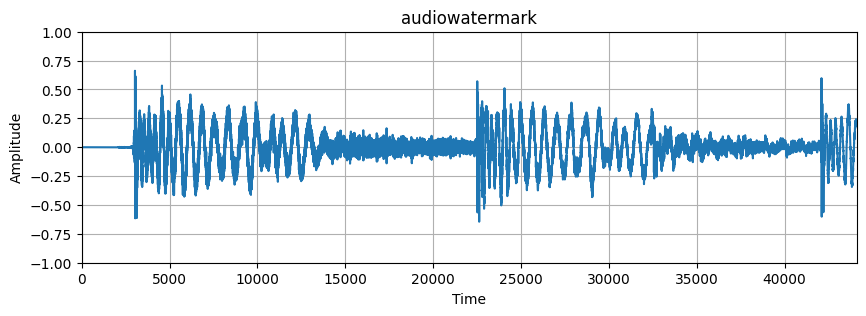

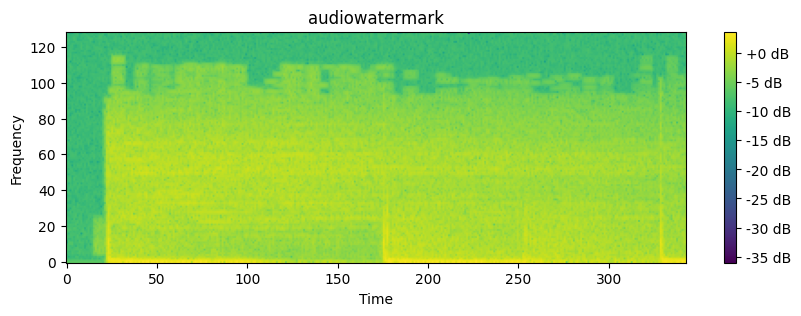

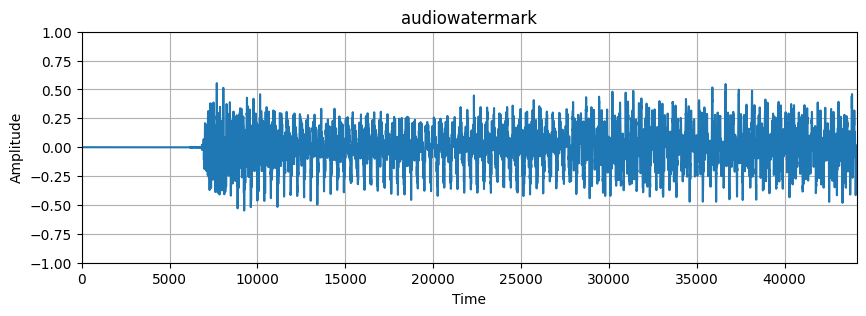

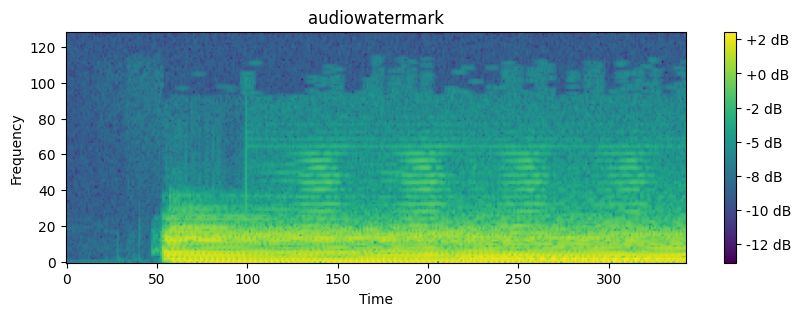

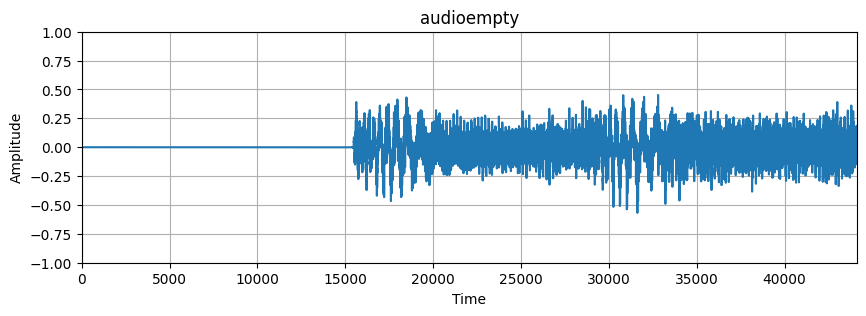

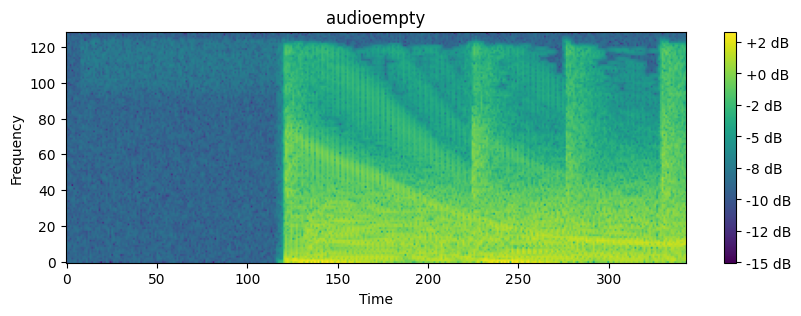

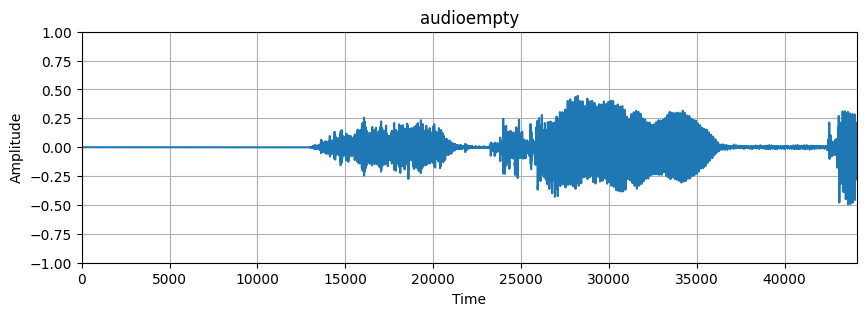

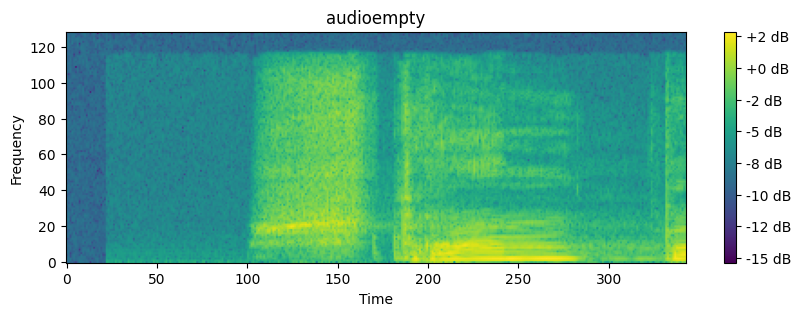

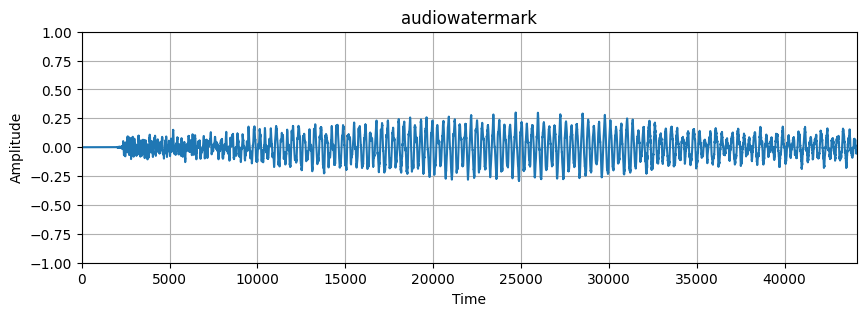

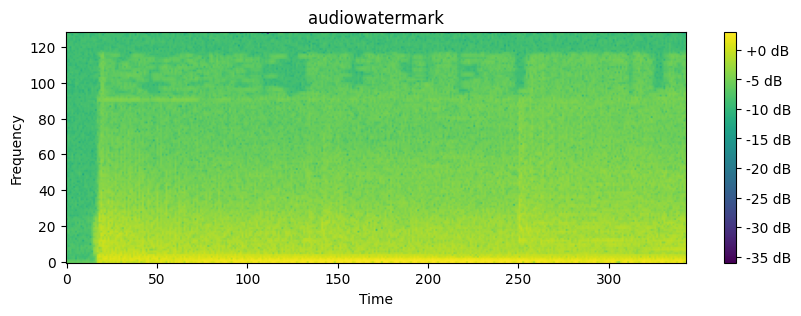

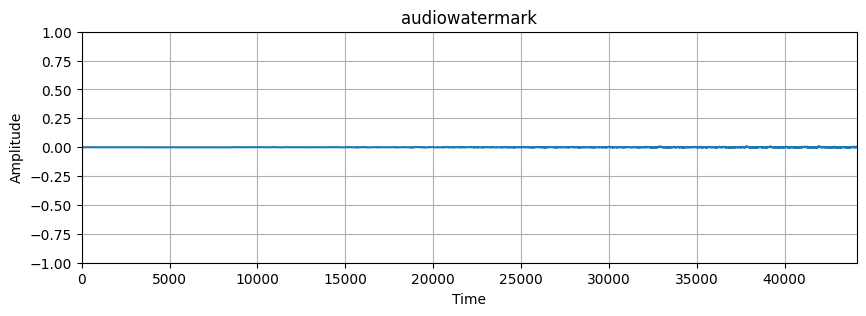

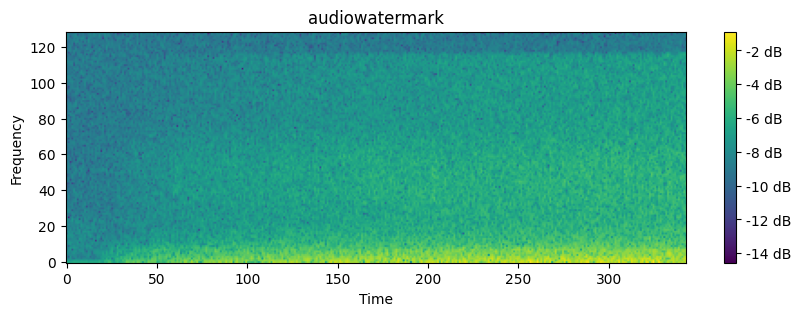

In [57]:
# Plot the waveform 
def plot_wave(waveform, label): 
	plt.figure(figsize=(10, 3)) 
	plt.title(label) 
	plt.plot(waveform) 
	plt.xlim([0, 44100]) 
	plt.ylim([-1, 1]) 
	plt.xlabel('Time') 
	plt.ylabel('Amplitude') 
	plt.grid(True) 

# Convert waveform to spectrogram 
def get_spectrogram(waveform): 
	spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
	spectrogram = tf.abs(spectrogram) ; spectrogram = tf.cast(spectrogram, tf.float64) # Change Data Type
	return spectrogram[..., tf.newaxis]

# Plot the spectrogram 
def plot_spectrogram(spectrogram, label): 
	spectrogram = np.squeeze(spectrogram, axis=-1) 
	log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
	plt.figure(figsize=(10, 3)) 
	plt.title(label) 
	plt.imshow(log_spec, aspect='auto', origin='lower') 
	plt.colorbar(format='%+2.0f dB') 
	plt.xlabel('Time') 
	plt.ylabel('Frequency') 

for i in range(6):
    # Plotting the waveform and the spectrogram of a random sample 
    audio, label = next(iter(training_set)) 
    
    # Plot the wave with its label name 
    plot_wave(audio[i], label_names[label[i]]) 
    
    # Plot the spectrogram with its label name 
    plot_spectrogram(get_spectrogram(audio[i]), label_names[label[i]])

In [33]:
# Creating spectrogram dataset from waveform or audio data 
def get_spectrogram_dataset(dataset): 
	dataset = dataset.map( 
		lambda x, y: (get_spectrogram(x), y), 
		num_parallel_calls=tf.data.AUTOTUNE) 
	return dataset 

# Applying the function on the audio dataset 
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 

# Dividing validation set into two equal val and test set 
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [34]:
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 

print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 343, 129, 1)
Validation set shape: (None, 343, 129, 1)
Testing set shape: (None, 343, 129, 1)


# *Можно создать последовательную модель*

In [55]:
# Defining the model 
def get_model(input_shape, num_labels): 
	model = tf.keras.Sequential([ 
		tf.keras.layers.Input(shape=input_shape), 
		# Resizing the input to a square image of size 64 x 64 and normalizing it 
		tf.keras.layers.Resizing(64, 64), 
		tf.keras.layers.Normalization(), 
		
		# Convolution layers followed by MaxPooling layer 
		tf.keras.layers.Conv2D(64, 3, activation='relu'), 
		tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.Conv2D(256, 3, activation='relu'),
        tf.keras.layers.Conv2D(512, 3, activation='relu'),
        tf.keras.layers.Conv2D(512, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(), 
		tf.keras.layers.Dropout(0.5), 
		tf.keras.layers.Flatten(), 
		
		# Dense layer 
        tf.keras.layers.Dense(512, activation='relu'), 
		tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'), 
		tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
		
		# Softmax layer to get the label prediction 
		tf.keras.layers.Dense(num_labels, activation='softmax')
	]) 
	# Printing model summary 
	model.summary() 
	return model 

# Getting input shape from the sample audio and number of classes 
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 

# Creating a model 
model = get_model(input_shape, num_labels)

Input shape: (343, 129, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_4 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_64 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_65 (Conv2D)          (None, 58, 58, 256)       295168    
                                                                 
 conv2d_66 (Conv2D)          (None, 56, 56, 512)       1180160   
                           

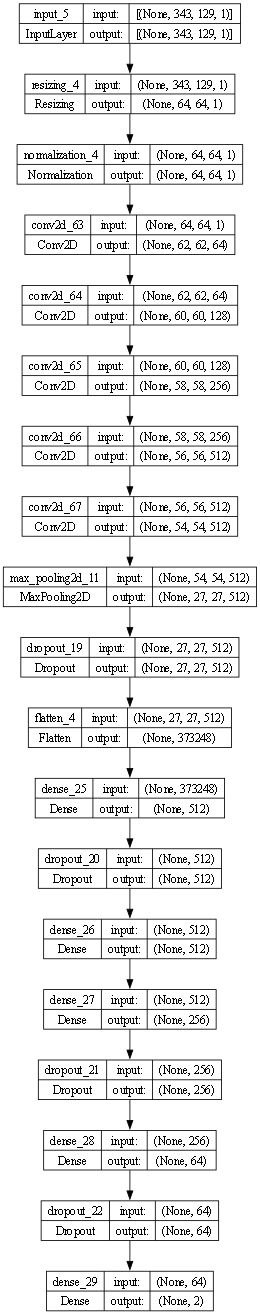

In [56]:
import keras
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True, to_file='audioclass.png')

# *Или можно создать ResNet-подобную модель*

In [49]:
# https://proproprogs.ru/tensorflow/keras-sozdaem-resnet-podobnuyu-arhitekturu-dlya-klassifikacii-izobrazheniy-cifar-10
from tensorflow import keras
from tensorflow.keras import layers

input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 


inputs = keras.Input(shape=input_shape, name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(128, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])
x = layers.Conv2D(128, 3, activation="relu", padding="same")(block_3_output)
block_4_output = layers.add([x, block_3_output])
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_labels, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Input shape: (343, 129, 1)
Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 343, 129, 1)]        0         []                            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 341, 127, 32)         320       ['img[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)          (None, 339, 125, 128)        36992     ['conv2d_55[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 113, 41, 128)         0         ['conv2d_56[0][0]']           
 ng2D)                                                        

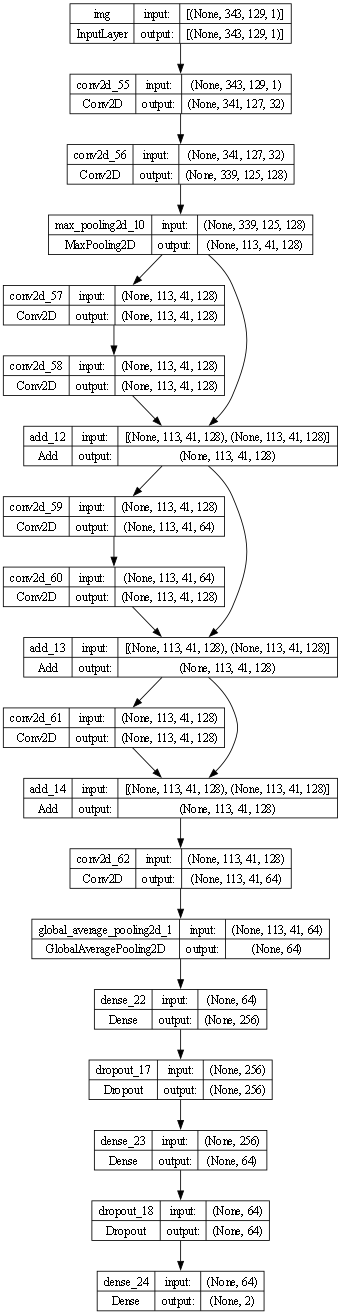

In [50]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True, to_file='toy_resnet_deep-audioclass.png')

**Переобучение** - распространенная проблема при обучении нейронных сетей. Это происходит, когда модель учится запоминать обучающие данные, а не обобщать на их основе шаблоны, что приводит к снижению производительности при работе с невидимыми данными. В то время как различные методы регуляризации, такие как отсев и снижение веса, могут помочь бороться с переобучением, ранняя остановка выделяется как простой, но эффективный метод предотвращения переобучения нейронных сетей.  

*Ранняя остановка* — это стратегия в машинном обучении, которая заключается в завершении алгоритма обучения, когда на протяжении заранее заданного числа итераций не удаётся улучшить параметры по сравнению с наилучшими, запомненными ранее. 
Ранняя остановка позволяет управлять эффективной ёмкостью модели, определяя, сколько шагов ей может потребоваться для аппроксимации обучающего набор 

Эта стратегия является самой распространённой формой регуляризации в машинном обучении и отличается простотой и эффективностью. Её можно использовать автономно или в сочетании с другими стратегиями регуляриза


## Преимущества ранней остановки:  + 
Предотвращает переобучение: Основная цель ранней остановки - предотвратить переобучение путем мониторинга производительности модели на валидационном наборе данных во время обучения. Останавливая процесс обучения, когда ошибка проверки начинает увеличиваться, ранняя остановка предотвращает чрезмерную сложность модели и запоминание шума в обучающих данных

.+ 
Экономит вычислительные ресурсы: Обучение глубоких нейронных сетей может быть трудоемким с точки зрения вычислений, особенно с большими наборами данных и сложной архитектурой. Ранняя остановка помогает экономить вычислительные ресурсы за счет прекращения процесса обучения, когда дальнейшее улучшение производительности проверки маловероятно. Это приводит к сокращению времени обучения и вычислительных затра

т+ .
Улучшает обобщение: Ограничивая переобучение, ранняя остановка побуждает модель лучше обобщать невидимые данные. Модели, обученные с использованием ранней остановки, демонстрируют повышенную производительность в невидимых наборах данных или реальных приложениях, поскольку они улавливают основные закономерности, не подверженные влиянию шума или несущественных детал

е+ й.
Простая реализация: В отличие от некоторых других методов регуляризации, которые требуют настройки гиперпараметров или модификации архитектуры модели, ранняя остановка проста в реализации и требует минимальных дополнительных усилий. Это включает мониторинг ошибки проверки во время обучения и остановку процесса, когда выполняется заранее определенный критерий, такой как отсутствие улучшений в течение определенного количества э


Mодель, обученная с использованием ранней остановки, менее склонна к переобучению и, скорее всего, лучше обобщит невидимые данные.
https://www.geeksforgeeks.org/using-early-stopping-to-reduce-overfitting-in-neural-networks/х.

ции.

In [51]:
model.compile( 
	optimizer=tf.keras.optimizers.Adam(), 
	loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
	metrics=['accuracy'], 
) 

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

EPOCHS = 100
history = model.fit( 
	train_set, 
	validation_data=val_set, 
	epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/100
40/40 [==============================] - 93s 2s/step - loss: 0.7011 - accuracy: 0.4875 - val_loss: 0.6961 - val_accuracy: 0.4000
Epoch 2/100
40/40 [==============================] - 91s 2s/step - loss: 0.6932 - accuracy: 0.5141 - val_loss: 0.6978 - val_accuracy: 0.4000
Epoch 3/100
40/40 [==============================] - 98s 2s/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6967 - val_accuracy: 0.4000
Epoch 4/100
40/40 [==============================] - 98s 2s/step - loss: 0.6935 - accuracy: 0.5125 - val_loss: 0.6982 - val_accuracy: 0.4000


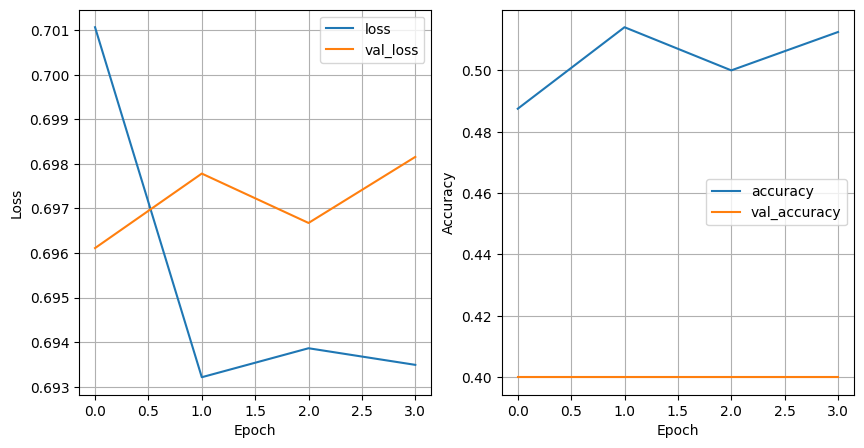

In [52]:
# Plotting the history 
metrics = history.history 
plt.figure(figsize=(10, 5)) 

# Plotting training and validation loss 
plt.subplot(1, 2, 1) 
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) 
plt.legend(['loss', 'val_loss']) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.grid()

# Plotting training and validation accuracy 
plt.subplot(1, 2, 2) 
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy']) 
plt.legend(['accuracy', 'val_accuracy']) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.grid()

5/5 [==============================] - 6s 641ms/step


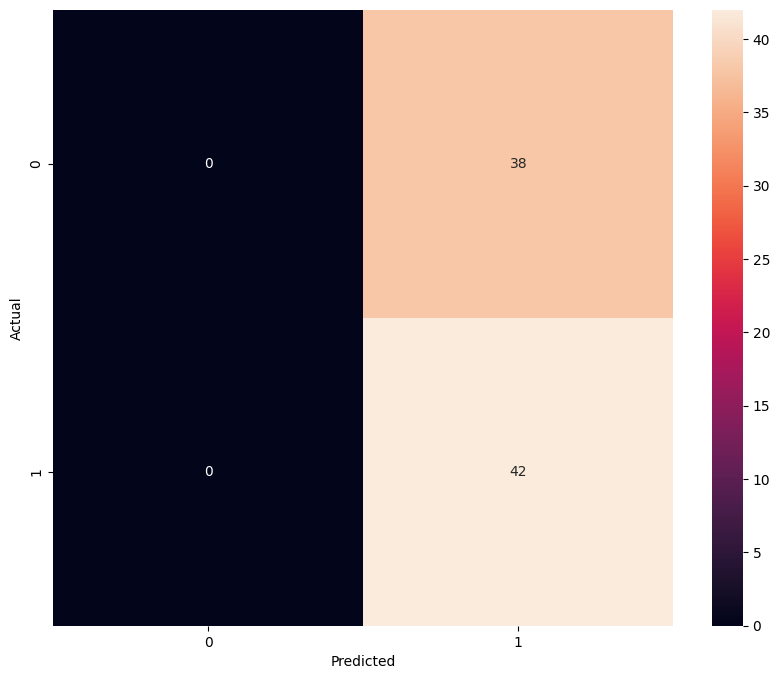

In [53]:
# Confusion matrix 
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 

# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [54]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.53      1.00      0.69        42

    accuracy                           0.53        80
   macro avg       0.26      0.50      0.34        80
weighted avg       0.28      0.53      0.36        80



C:\Users\Peter\AppData\Local\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Peter\AppData\Local\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Peter\AppData\Local\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

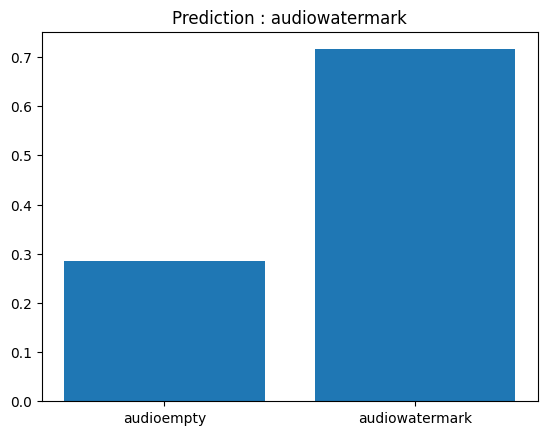

In [20]:
path = 'audiodataset/audiowatermark/11.wav'
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=44100,) 
audio, labels = squeeze(x, 'audiowatermark') 

waveform = audio 
display.display(display.Audio(waveform, rate=44100)) 

x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 

prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+ label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()